In [0]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
# Check if the mounted file is accessible
import os
files = os.listdir('drive/My Drive/COVID-19')
print(len(files))

15


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *
import torchvision
from fastai.metrics import *
from fastai.callbacks import *
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm
from skimage.exposure import equalize_adapthist as clahe
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [0]:
print('Make sure cuda is installed:', torch.cuda.is_available())
print('Make sure cudnn is enabled:', torch.backends.cudnn.enabled)

Make sure cuda is installed: True
Make sure cudnn is enabled: True


In [0]:
sample_df = pd.read_csv("drive/My Drive/COVID-19/Dataset3/TrainData/sample_labels.csv")
sample_df = sample_df.sample(frac = 1, random_state = 2020).reset_index(drop = True) #shuffle dataframe

In [0]:
# Convert Age to Integer
idx = []
for i in range(sample_df.shape[0]):
  try:
    sample_df['Patient Age'].iloc[i] = int(sample_df['Patient Age'].iloc[i].split('Y')[0])
  except:
    idx.append(i)

sample_df.drop(sample_df.index[idx], inplace = True)
# Filter Age
sample_df = sample_df[sample_df['Patient Age'] >= 30]
# Filter Normal Labels
normal_df = sample_df[sample_df['Finding Labels'] == 'No Finding']
# Filter Other Disease Labels
df1 = sample_df[sample_df['Finding Labels'] == 'Atelectasis']
df2 = sample_df[sample_df['Finding Labels'] == 'Consolidation']
df3 = sample_df[sample_df['Finding Labels'] == 'Pneumothorax']
df4 = sample_df[sample_df['Finding Labels'] == 'Edema']
df5 = sample_df[sample_df['Finding Labels'] == 'Emphysema']
df6 = sample_df[sample_df['Finding Labels'] == 'Fibrosis']
df7 = sample_df[sample_df['Finding Labels'] == 'Effusion']
df8 = sample_df[sample_df['Finding Labels'] == 'Cardiomegaly']
df9 = sample_df[sample_df['Finding Labels'] == 'Hernia']

nonCovid_df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9])
# Sample Image based on View Position
normal_df = normal_df.groupby('View Position').apply(lambda x: x.sample(511))
nonCovid_df = nonCovid_df.groupby('View Position').apply(lambda x: x.sample(115))

len(nonCovid_df['Finding Labels'].unique())

9

In [0]:
normal_df.shape, nonCovid_df.shape

((1022, 11), (230, 11))

# Load Training Data

In [0]:
# Load Dataset Path
img_list = []
lab_list = []

# COVID
for file in tqdm(os.listdir("drive/My Drive/COVID-19/Dataset2/TrainData/COVID-19")):
  img_list.append(os.path.join("drive/My Drive/COVID-19/Dataset2/TrainData/COVID-19", file))
  lab_list.append("COVID-PATIENT")

# COVID: Viral Pneumonia
for file in tqdm(os.listdir("drive/My Drive/COVID-19/Dataset2/TrainData/Viral-Pneumonia")):
  img_list.append(os.path.join("drive/My Drive/COVID-19/Dataset2/TrainData/Viral-Pneumonia", file))
  lab_list.append("COVID-PATIENT")
'''
# NON-COVID
for file in tqdm(nonCovid_df['Image Index'].values):
  img_list.append(os.path.join("drive/My Drive/COVID-19/Dataset3/TrainData/Images", file))
  lab_list.append("NON-COVID-PATIENT")
'''
# NON COVID: NORMAL
for file in tqdm(normal_df['Image Index'].values):
  img_list.append(os.path.join("drive/My Drive/COVID-19/Dataset3/TrainData/Images", file))
  lab_list.append("NON-COVID-PATIENT")

len(img_list)

100%|██████████| 1022/1022 [00:00<00:00, 363023.26it/s]


2043

In [0]:
df = pd.DataFrame(list(zip(img_list, lab_list)), columns = ['path', 'label'])
df = df.sample(frac = 1, random_state = 2020).reset_index(drop = True) #shuffle dataframe
df.head()

,path,label
0,drive/My Drive/COVID-19/Dataset2/TrainData/Vir...,COVID-PATIENT
1,drive/My Drive/COVID-19/Dataset3/TrainData/Ima...,NON-COVID-PATIENT
2,drive/My Drive/COVID-19/Dataset2/TrainData/Vir...,COVID-PATIENT
3,drive/My Drive/COVID-19/Dataset2/TrainData/Vir...,COVID-PATIENT
4,drive/My Drive/COVID-19/Dataset3/TrainData/Ima...,NON-COVID-PATIENT


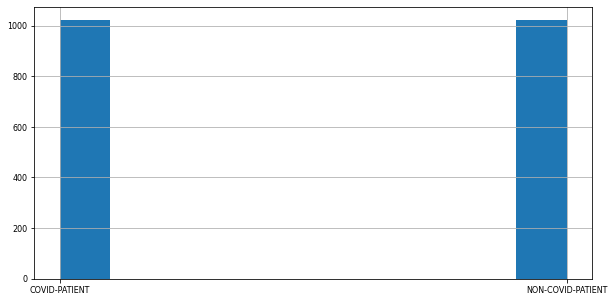

In [0]:
df['label'].hist(figsize = (10, 5), xlabelsize = 8, ylabelsize = 8)

In [0]:
train_df, val_df = train_test_split(df, test_size = 0.2, random_state = 2020)

409

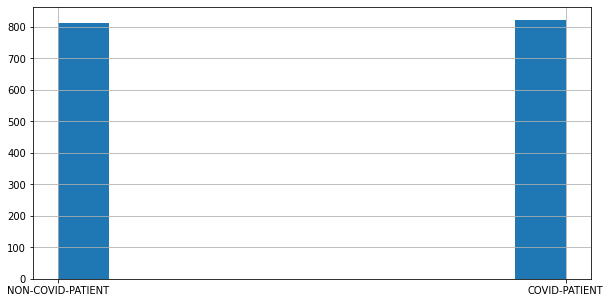

In [0]:
train_df['label'].hist(figsize = (10, 5))
len(val_df)

In [0]:
df = pd.concat([train_df, val_df]) #beginning of this dataframe is the training set, end is the validation set
len(df)

2043

# Load Image from Image Path

In [0]:
# Custom Transformation
def custom_tfms(x):
  npimg = image2np(x) * 255
  npimg = npimg.astype(np.uint8)

  #Histogram Equalization
  trans_img = clahe(npimg)

  return pil2tensor(trans_img, dtype = np.float32)

In [0]:
batch_size = 8 #smaller batch size is better for training, but may take longer
img_size = 512 

In [0]:
#Load the dataset into the ImageItemList class provided by fastai
custom_trans = TfmPixel(custom_tfms)
tfms = get_transforms(do_flip = True, flip_vert = True, max_rotate = None, max_warp = 0, max_zoom = 1.0, max_lighting = 0.1, p_lighting = 0.5, xtra_tfms = custom_trans())

src = (ImageList.from_df(df = df, path = './',cols = 'path') #get dataset from dataset
        .split_by_idx(range(len(train_df)-1, len(df))) #Splitting the dataset
        .label_from_df(cols = 'label')
      )
data = (src.transform(tfms, size = img_size, resize_method = ResizeMethod.SQUISH) #Pre-processing
        .databunch(bs = batch_size, num_workers = 8) #DataBunch
        .normalize(imagenet_stats) #Normalize     
       )

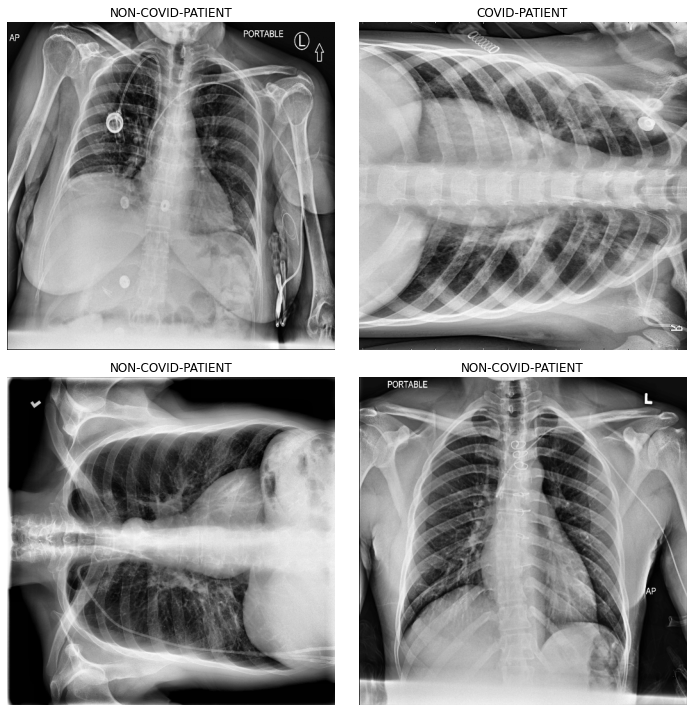

In [0]:
data.show_batch(rows = 2, figsize = (10, 10))

In [0]:
classes = data.classes
print(data.classes)
len(data.classes), data.c 

['COVID-PATIENT', 'NON-COVID-PATIENT']


(2, 2)

# Classification

In [0]:
# Training using Transfer Learning
learn = cnn_learner(data, models.densenet121, wd = 1e-3, metrics = [accuracy, Precision(average = 'macro'), Recall(average = 'macro')], callback_fns = [partial(CSVLogger, append = True)])

# Training

In [0]:
# Use the learning-rate finder to optimize the learning rate
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [22]:
learn.fit_one_cycle(20, max_lr = slice(1e-5, 1e-3), callbacks = [SaveModelCallback(learn, every = 'epoch')])

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.347997,0.324400,0.912195,0.927126,0.909548,03:18
1,0.271328,0.220776,0.941463,0.948936,0.939698,03:04
2,0.191755,0.118620,0.970732,0.973094,0.969849,03:03
3,0.231251,0.197426,0.934146,0.942042,0.932304,03:03
4,0.175633,0.280473,0.948780,0.954741,0.947236,03:04
5,0.179115,0.075050,0.978049,0.979545,0.977387,03:06
6,0.144110,0.117069,0.970732,0.973094,0.969849,03:06
7,0.204202,0.052854,0.980488,0.981735,0.979900,03:05
8,0.107920,0.163359,0.946341,0.952790,0.944724,03:07
9,0.145578,0.222069,0.934146,0.943277,0.932161,03:07


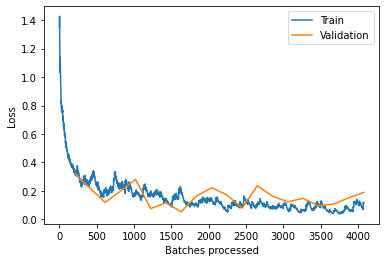

In [23]:
learn.recorder.plot_losses()

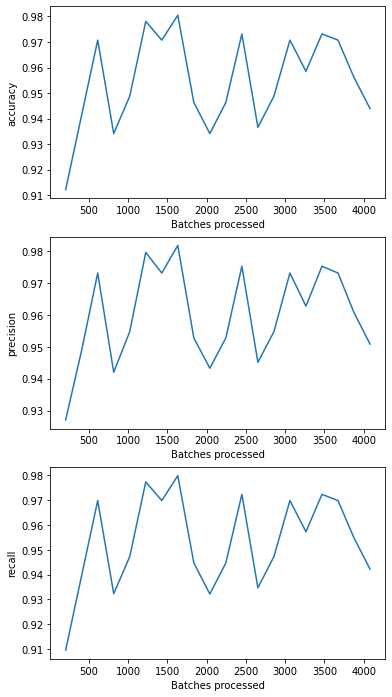

In [24]:
learn.recorder.plot_metrics()

In [29]:
learn.load("bestmodel_7")

Learner(data=ImageDataBunch;

Train: LabelList (1633 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
NON-COVID-PATIENT,NON-COVID-PATIENT,NON-COVID-PATIENT,COVID-PATIENT,COVID-PATIENT
Path: .;

Valid: LabelList (410 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
NON-COVID-PATIENT,NON-COVID-PATIENT,COVID-PATIENT,COVID-PATIENT,COVID-PATIENT
Path: .;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): Bat

In [30]:
# Check Result
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

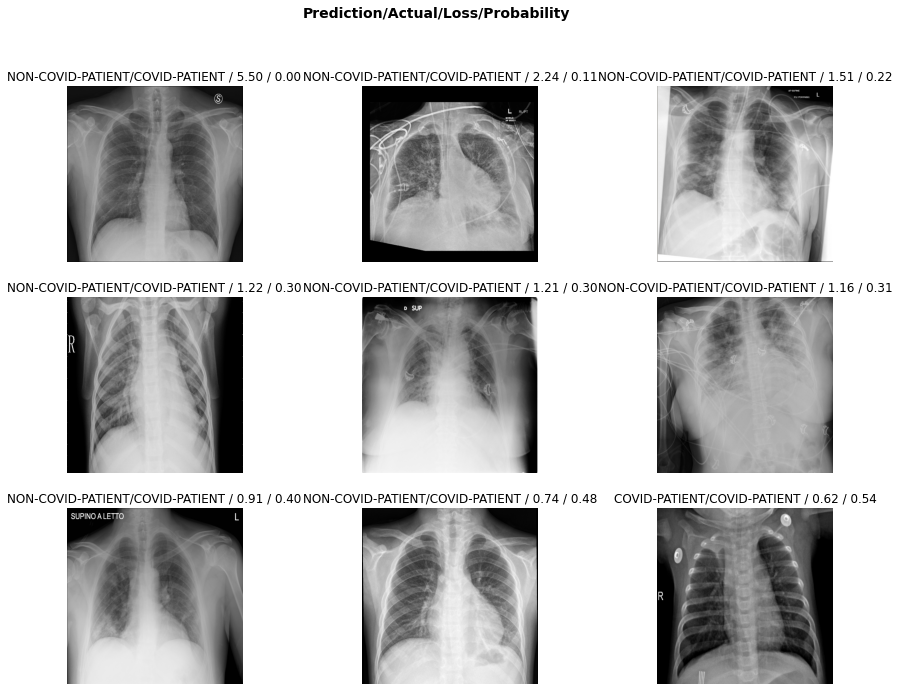

In [31]:
interp.plot_top_losses(9, figsize = (15, 11))

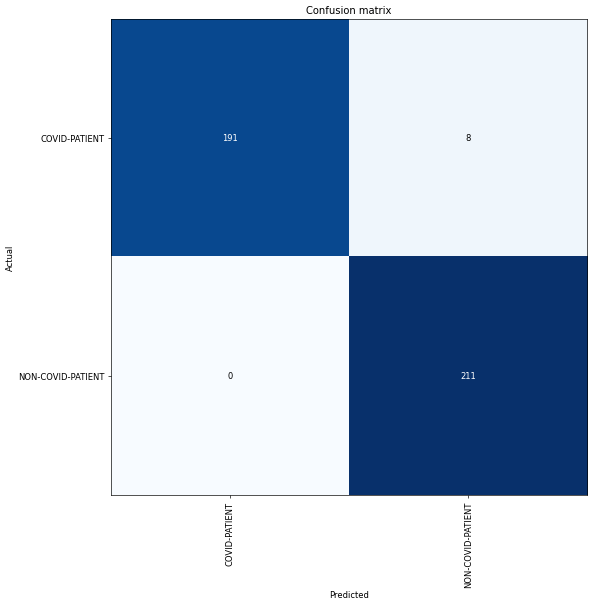

In [32]:
interp.plot_confusion_matrix(figsize = (10, 10), dpi = 60)

In [33]:
probs, val_labels = learn.get_preds(ds_type = DatasetType.Valid) 

In [34]:
pred_labels = np.argmax(probs, axis = -1)
pred_labels

tensor([1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
        1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
        0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
        1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
        0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
        1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
        0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
        0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0,

(array([211.,   6.,   2.,   2.,   9., 180.]),
 array([2.438350e-06, 1.666684e-01, 3.333344e-01, 5.000004e-01, 6.666664e-01, 8.333324e-01, 9.999985e-01], dtype=float32),
 <a list of 6 Patch objects>)

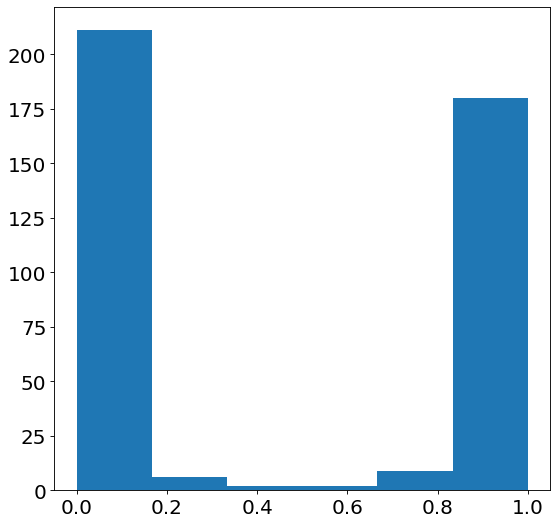

In [35]:
plt.rcParams.update({'font.size': 18})
plt.figure(num = None, figsize = (8, 8), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.hist(probs[:, 0], bins = 6)

In [0]:
learn.export()

# X-Ray Clinical Data Prediction

In [37]:
# Load Dataset Path
img_list = []
lab_list = []

# COVID
for file in tqdm(os.listdir("drive/My Drive/COVID-19/ClinicalDataset/mohan_data_crop/COVID")):
  img_list.append(os.path.join("drive/My Drive/COVID-19/ClinicalDataset/mohan_data_crop/COVID", file))
  lab_list.append("COVID-PATIENT")

# NORMAL PA
for file in tqdm(os.listdir("drive/My Drive/COVID-19/ClinicalDataset/Other_data/NORMAL")):
  img_list.append(os.path.join("drive/My Drive/COVID-19/ClinicalDataset/Other_data/NORMAL", file))
  lab_list.append("NON-COVID-PATIENT")
'''
# Viral Pneumonia
for file in tqdm(os.listdir("drive/My Drive/COVID-19/Dataset2/TrainData/Viral-Pneumonia")[400:420]):
  img_list.append(os.path.join("drive/My Drive/COVID-19/Dataset2/TrainData/Viral-Pneumonia", file))
  lab_list.append("VIRAL-PNEUMONIA-AP-PATIENT")

# NORMAL AP
for file in tqdm(sample_df_ap['Image Index'].values[400:420]):
  img_list.append(os.path.join("drive/My Drive/COVID-19/Dataset3/TrainData/Images", file))
  lab_list.append("NON-COVID-PATIENT")
'''

len(img_list)

100%|██████████| 6/6 [00:00<00:00, 12820.08it/s]


31

In [0]:
test_df = pd.DataFrame(list(zip(img_list, lab_list)), columns = ['path', 'Actual_label'])
#test_df = test_df.sample(frac = 1, random_state = 2020).reset_index(drop = True) #shuffle dataframe

In [39]:
#pd.set_option('display.max_rows', 100)
test_df.head()

,path,Actual_label
0,drive/My Drive/COVID-19/ClinicalDataset/mohan_...,COVID-PATIENT
1,drive/My Drive/COVID-19/ClinicalDataset/mohan_...,COVID-PATIENT
2,drive/My Drive/COVID-19/ClinicalDataset/mohan_...,COVID-PATIENT
3,drive/My Drive/COVID-19/ClinicalDataset/mohan_...,COVID-PATIENT
4,drive/My Drive/COVID-19/ClinicalDataset/mohan_...,COVID-PATIENT


In [0]:
test_learn = load_learner('', test = ImageList.from_df(df = test_df, path = './', cols = 'path'))

In [41]:
pred_probabs, val = test_learn.get_preds(ds_type = DatasetType.Test)
pred_labels = np.argmax(pred_probabs, axis = -1) 

In [42]:
dictionary = {0: classes[0], 1: classes[1]}

#Prediction
infer = [dictionary[p.item()] for p in pred_labels]
#Probability
probability = [pro.max().item() for pro in pred_probabs]

len(infer), len(probability)

(31, 31)

In [0]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', -1)

In [44]:
new_test_df = pd.DataFrame({'Actual label': test_df['Actual_label'], 'Predicted label': infer, 'Probability': probability, 'Image_Path': test_df['path']})
new_test_df.head()

,Actual label,Predicted label,Probability,Image_Path
0,COVID-PATIENT,COVID-PATIENT,1.0,drive/My Drive/COVID-19/ClinicalDataset/mohan_data_crop/COVID/WhatsApp Image 2020-04-25 at 10.45.03.jpeg
1,COVID-PATIENT,COVID-PATIENT,1.0,drive/My Drive/COVID-19/ClinicalDataset/mohan_data_crop/COVID/WhatsApp Image 2020-04-25 at 10.45.04 (1).jpeg
2,COVID-PATIENT,COVID-PATIENT,1.0,drive/My Drive/COVID-19/ClinicalDataset/mohan_data_crop/COVID/WhatsApp Image 2020-04-25 at 10.45.04.jpeg
3,COVID-PATIENT,COVID-PATIENT,1.0,drive/My Drive/COVID-19/ClinicalDataset/mohan_data_crop/COVID/WhatsApp Image 2020-04-25 at 10.45.05 (1).jpeg
4,COVID-PATIENT,COVID-PATIENT,1.0,drive/My Drive/COVID-19/ClinicalDataset/mohan_data_crop/COVID/WhatsApp Image 2020-04-25 at 10.45.05 (2).jpeg


In [45]:
# Check for Correct Prediction
check = new_test_df['Actual label'] == new_test_df['Predicted label']
count = 0
for i in range(len(check)):
  if (check[i]):
    count = count + 1

print(count)

26


In [46]:
print(classification_report(new_test_df['Actual label'], new_test_df['Predicted label']))

                   precision    recall  f1-score   support

    COVID-PATIENT       0.83      1.00      0.91        25
NON-COVID-PATIENT       1.00      0.17      0.29         6

         accuracy                           0.84        31
        macro avg       0.92      0.58      0.60        31
     weighted avg       0.87      0.84      0.79        31



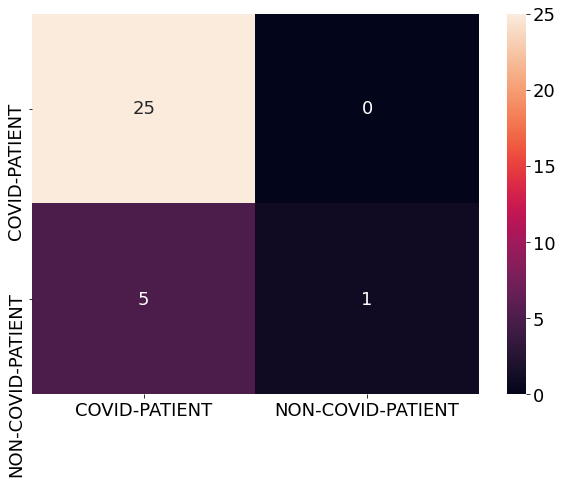

In [47]:
arr = confusion_matrix(new_test_df['Actual label'], new_test_df['Predicted label']), np.unique(new_test_df['Actual label'])
df_cm = pd.DataFrame(arr[0], index = classes, columns = classes)
plt.figure(figsize = (10, 7))
sns.heatmap(df_cm, annot = True)